In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

from ssd import SSD300
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


## Version check
```
cv2==3.3.0
keras==1.2.2
matplotlib==2.1.0
tensorflow==1.3.0
numpy==1.13.3
```

In [2]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

In [3]:
input_shape=(300, 300, 3)
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

In [4]:
try:
    from PIL import Image as pil_image
except ImportError:
    pil_image = None
    

if pil_image is not None:
    _PIL_INTERPOLATION_METHODS = {
        'nearest': pil_image.NEAREST,
        'bilinear': pil_image.BILINEAR,
        'bicubic': pil_image.BICUBIC,
    }
    # These methods were only introduced in version 3.4.0 (2016).
    if hasattr(pil_image, 'HAMMING'):
        _PIL_INTERPOLATION_METHODS['hamming'] = pil_image.HAMMING
    if hasattr(pil_image, 'BOX'):
        _PIL_INTERPOLATION_METHODS['box'] = pil_image.BOX
    # This method is new in version 1.1.3 (2013).
    if hasattr(pil_image, 'LANCZOS'):
        _PIL_INTERPOLATION_METHODS['lanczos'] = pil_image.LANCZOS
    
def load_img(path, grayscale=False, target_size=None,
             interpolation='nearest'):
    """Loads an image into PIL format.
    # Arguments
        path: Path to image file
        grayscale: Boolean, whether to load the image as grayscale.
        target_size: Either `None` (default to original size)
            or tuple of ints `(img_height, img_width)`.
        interpolation: Interpolation method used to resample the image if the
            target size is different from that of the loaded image.
            Supported methods are "nearest", "bilinear", and "bicubic".
            If PIL version 1.1.3 or newer is installed, "lanczos" is also
            supported. If PIL version 3.4.0 or newer is installed, "box" and
            "hamming" are also supported. By default, "nearest" is used.
    # Returns
        A PIL Image instance.
    # Raises
        ImportError: if PIL is not available.
        ValueError: if interpolation method is not supported.
    """
    if pil_image is None:
        raise ImportError('Could not import PIL.Image. '
                          'The use of `array_to_img` requires PIL.')
    img = pil_image.open(path)
    if grayscale:
        if img.mode != 'L':
            img = img.convert('L')
    else:
        if img.mode != 'RGB':
            img = img.convert('RGB')
    if target_size is not None:
        width_height_tuple = (target_size[1], target_size[0])
        if img.size != width_height_tuple:
            if interpolation not in _PIL_INTERPOLATION_METHODS:
                raise ValueError(
                    'Invalid interpolation method {} specified. Supported '
                    'methods are {}'.format(
                        interpolation,
                        ", ".join(_PIL_INTERPOLATION_METHODS.keys())))
            resample = _PIL_INTERPOLATION_METHODS[interpolation]
            img = img.resize(width_height_tuple, resample)
    return img

In [10]:
inputs = []
images = []
img_path = './pics/Aeroplane.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(plt.imread(img_path))
inputs.append(img.copy())
img_path = './pics/Cat.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(plt.imread(img_path))
inputs.append(img.copy())
img_path = './pics/Bicycle.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(plt.imread(img_path))
inputs.append(img.copy())
img_path = './pics/Car.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(plt.imread(img_path))
inputs.append(img.copy())
img_path = './pics/Dog.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(plt.imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

In [11]:
preds = model.predict(inputs, batch_size=1, verbose=1)

5/5 [==============================] - 2s     


In [12]:
results = bbox_util.detection_out(preds)

In [13]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds)

CPU times: user 544 ms, sys: 52 ms, total: 596 ms
Wall time: 2.35 s


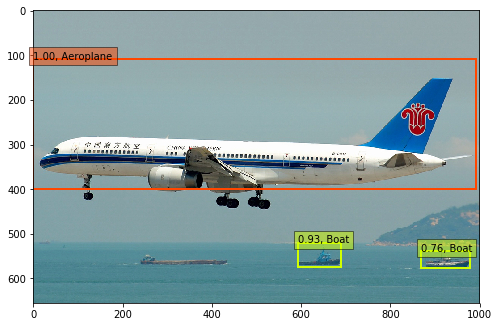

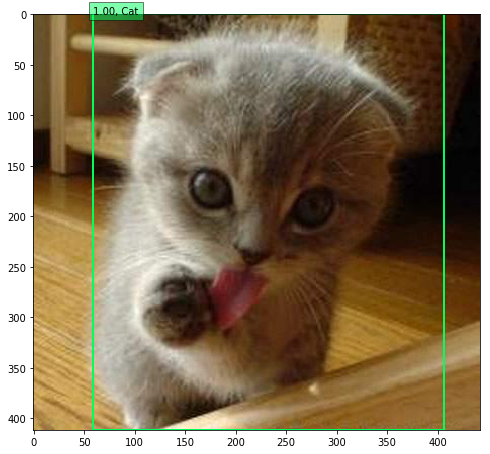

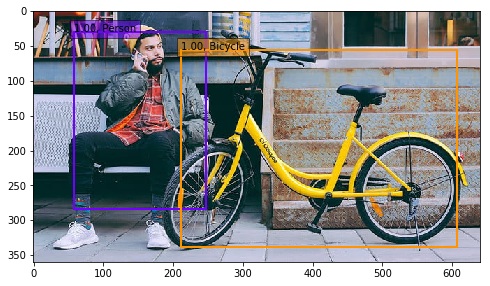

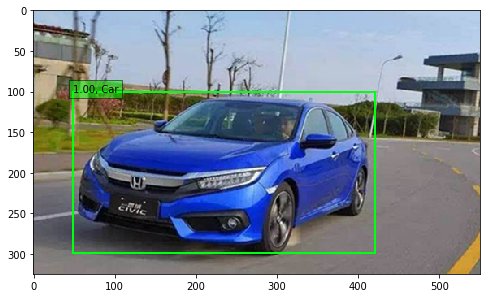

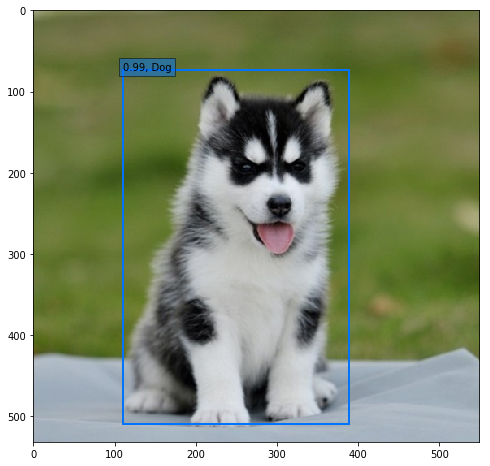

In [14]:
for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()